# This notebook aims to give a exploratory look at the project data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import rioxarray as rxr
import cartopy.crs as ccrs

In [2]:
ESM5_data = xr.open_dataset("/Users/filipnovak/Documents/ML_geosciences/CanESM5_hist_rsut.nc", engine="netcdf4")

## Variables and dimensions
- **Dimensions**:
  - `member` (25): ensemble members.
  - `time` (1980): monthly steps from 1850–2014 (noleap calendar).
  - `lat` (64), `lon` (128): spatial grid.
  - `bnds` (2): bounds for time/lat/lon intervals.
- **Coordinates**: `member`, `time`, `lat`, `lon`.
- **Data variables**:
  - `rsut`: reflected (outgoing) shortwave radiation at the top of the atmosphere in W m⁻² `(member, time, lat, lon)`.
  - `time_bnds`, `lat_bnds`, `lon_bnds`: bounds for each coordinate.

<xarray.Dataset> Size: 2GB
Dimensions:    (member: 25, time: 1980, bnds: 2, lat: 64, lon: 128)
Coordinates:
  * member     (member) int64 200B 0 1 2 3 4 5 6 7 8 ... 17 18 19 20 21 22 23 24
  * time       (time) object 16kB 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
  * lat        (lat) float64 512B -87.86 -85.1 -82.31 ... 82.31 85.1 87.86
  * lon        (lon) float64 1kB 0.0 2.812 5.625 8.438 ... 351.6 354.4 357.2
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (member, time, bnds) object 792kB ...
    lat_bnds   (member, lat, bnds) float64 26kB ...
    lon_bnds   (member, lon, bnds) float64 51kB ...
    rsut       (member, time, lat, lon) float32 2GB ...
Attributes: (12/53)
    CCCma_model_hash:            8ac7a3c953a92eb65289508ded4d1b280d2bae9e
    CCCma_parent_runid:          p2-pictrl
    CCCma_pycmor_hash:           7880b4e31048563c92850e9856f9d6ab6a78b953
    CCCma_runid:                 p2-his01
    Conventions:                 CF-1.7 CMIP-6.2
    YMDH_bran

/var/folders/g2/cdqgt5_n6_qgq1m_sjk9x3r00000gn/T/ipykernel_85653/3466869039.py:23: FutureWarning: In a future version of xarray to_datetimeindex will default to returning a 'us'-resolution DatetimeIndex instead of a 'ns'-resolution DatetimeIndex. This warning can be silenced by explicitly passing the `time_unit` keyword argument.
  da = da.assign_coords(time=da.indexes["time"].to_datetimeindex())
/var/folders/g2/cdqgt5_n6_qgq1m_sjk9x3r00000gn/T/ipykernel_85653/3466869039.py:23: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  da = da.assign_coords(time=da.indexes["time"].to_datetimeindex())


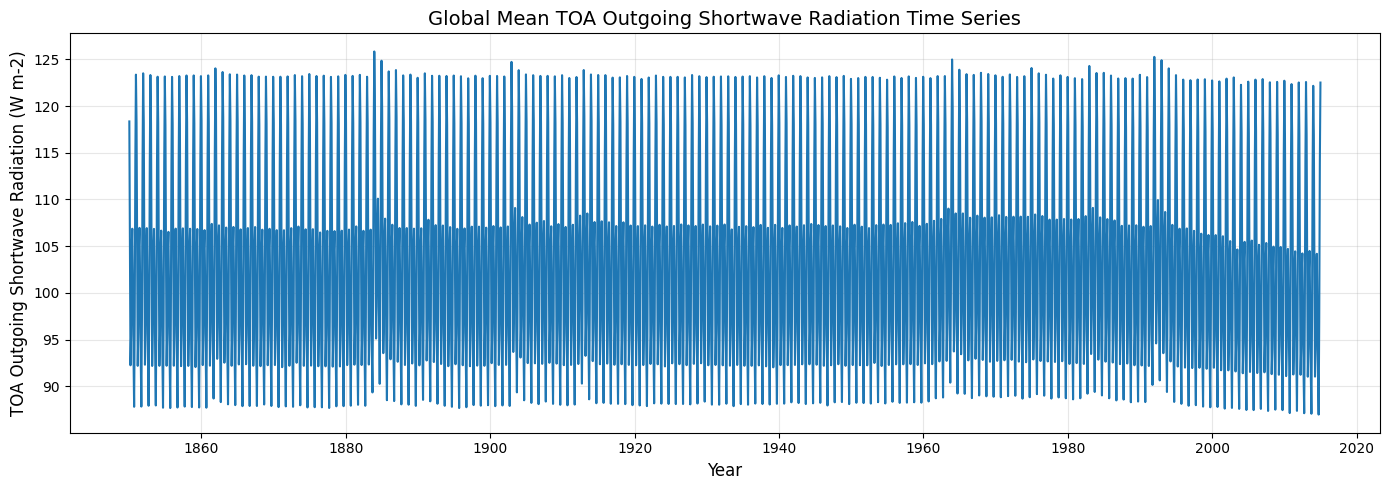

In [3]:
# Dataset overview
print(ESM5_data)
print("\nDimensions:", ESM5_data.dims)
print("Coordinates:", list(ESM5_data.coords))
print("Data variables:", list(ESM5_data.data_vars))

# Prefer the primary climate variable if present
if "rsut" in ESM5_data.data_vars:
    var_name = "rsut"
else:
    # Fall back to the first non-bounds variable
    non_bnds = [v for v in ESM5_data.data_vars if not v.endswith("_bnds")]
    var_name = non_bnds[0] if non_bnds else list(ESM5_data.data_vars)[0]
da = ESM5_data[var_name]
print("\nSelected variable:", var_name)
print(da)

print(type(da.time.values[0]))

# Convert time to pandas datetime if needed (avoid nc-time-axis requirement)
if "time" in da.coords:
    try:
        da = da.assign_coords(time=da.indexes["time"].to_datetimeindex())
    except Exception:
        pass

if "time" in da.dims:

    spatial_dims = [d for d in da.dims if d not in ["time", "member"]]

    if spatial_dims:
        ts = da.mean(spatial_dims)

        # Optional: ensemble mean
        if "member" in ts.dims:
            ts = ts.mean("member")

        fig, ax = plt.subplots(figsize=(14, 5))
        ts.plot(ax=ax, linewidth=1.5)

        units = da.attrs.get("units", "")
        long_name = da.attrs.get("long_name", var_name)

        ax.set_xlabel("Year", fontsize=12)
        ax.set_ylabel(f"{long_name} ({units})", fontsize=12)
        ax.set_title(f"Global Mean {long_name} Time Series", fontsize=14)
        ax.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

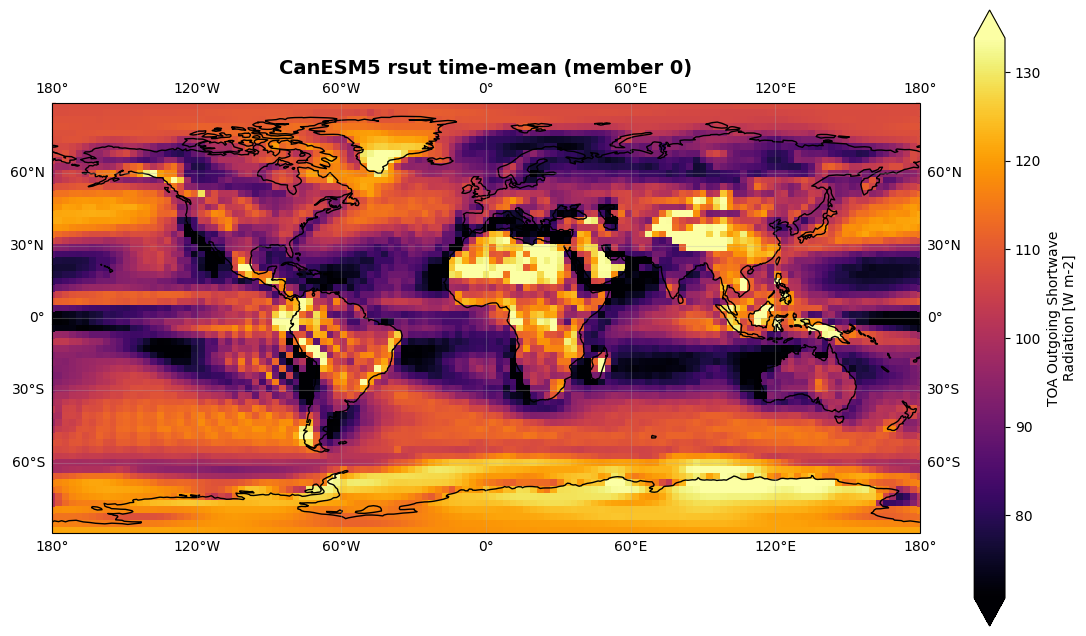

In [ ]:
# Map of rsut (time-mean, member 0)
map_da = ESM5_data["rsut"]
if "time" in map_da.dims:
    map_da = map_da.mean("time")
if "member" in map_da.dims:
    map_da = map_da.isel(member=0)

fig = plt.figure(figsize=(14, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=1)
ax.gridlines(draw_labels=True, alpha=0.3)

map_da.plot(ax=ax, transform=ccrs.PlateCarree(), cmap="inferno", robust=True, x="lon", y="lat")
plt.title("CanESM5 rsut time-mean (member 0)", fontsize=14, fontweight="bold")
plt.show()


In [5]:
rsut = ESM5_data["rsut"]

lon = rsut.lon
lat = rsut.lat
min_lon = lon.min()
max_lon = lon.max()
min_lat = lat.min()
max_lat = lat.max()

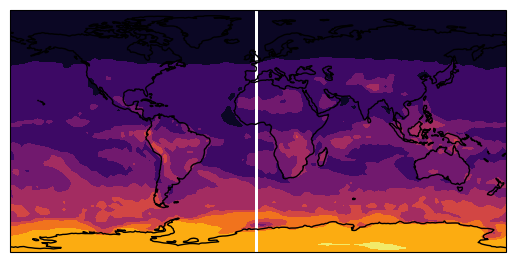

In [6]:
# This shows the amount of solar radiation received at time zero (1850)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.contourf(lon, lat, rsut.isel(time=0, member=0), transform=ccrs.PlateCarree(), cmap="inferno")

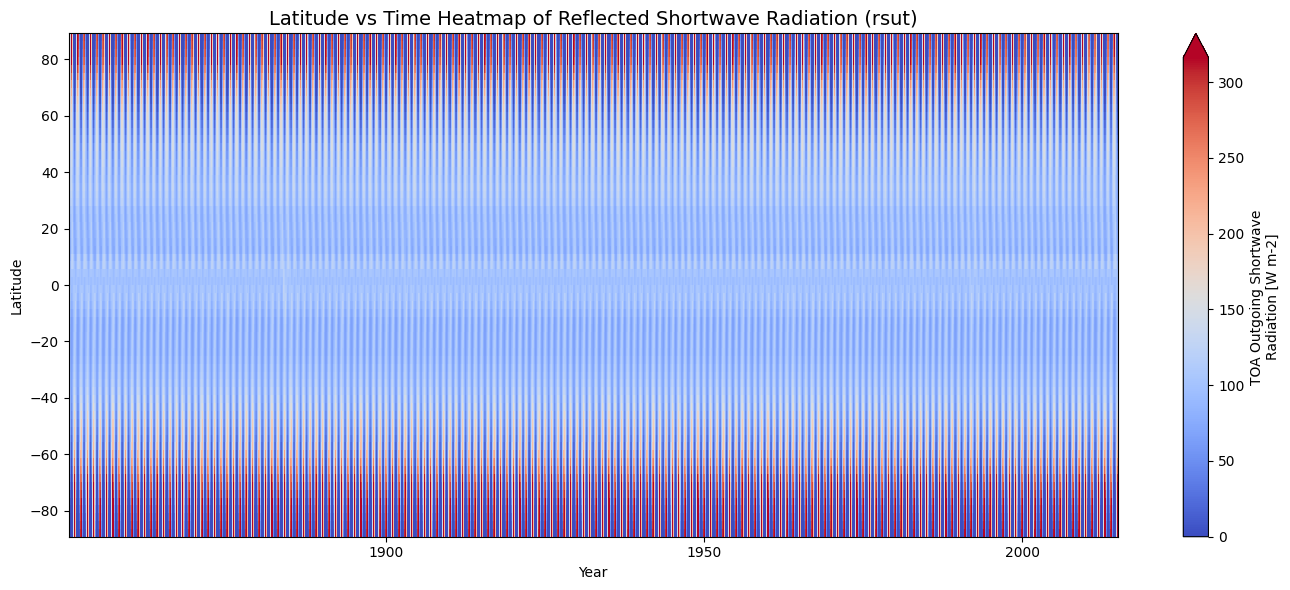

In [7]:
rsut = ESM5_data["rsut"]

# Average over longitude
lat_time = rsut.mean("lon")

# Ensemble mean
if "member" in lat_time.dims:
    lat_time = lat_time.mean("member")

# Plot
fig, ax = plt.subplots(figsize=(14, 6))

lat_time.plot(
    ax=ax,
    x="time",
    y="lat",
    cmap="coolwarm",
    robust=True
)

ax.set_title("Latitude vs Time Heatmap of Reflected Shortwave Radiation (rsut)", fontsize=14)
ax.set_xlabel("Year")
ax.set_ylabel("Latitude")

plt.tight_layout()
plt.show()


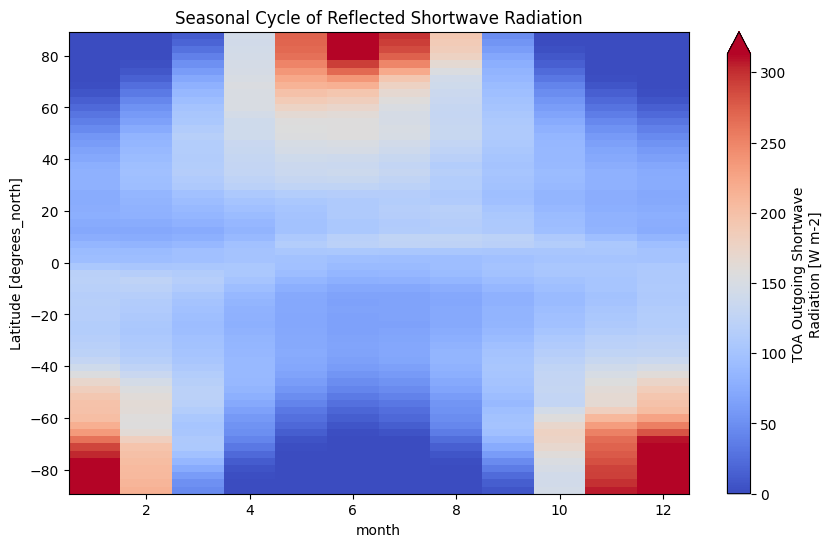

In [8]:
seasonal = lat_time.groupby("time.month").mean("time")

fig, ax = plt.subplots(figsize=(10, 6))

seasonal.plot(
    ax=ax,
    x="month",
    y="lat",
    cmap="coolwarm",
    robust=True
)

ax.set_title("Seasonal Cycle of Reflected Shortwave Radiation")
plt.show()

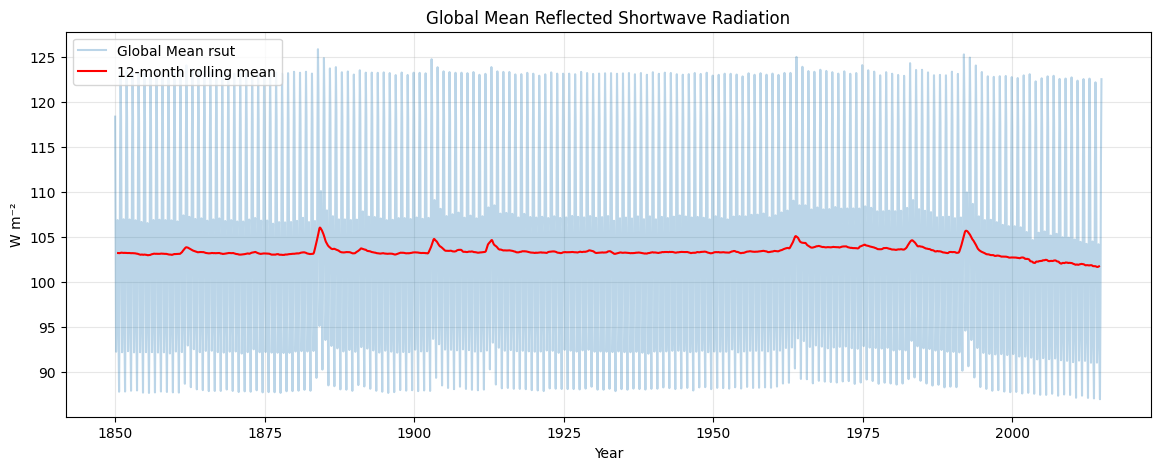

Trend = -0.00120 W m⁻² per year


In [13]:
rsut = ESM5_data["rsut"]

# Global mean
global_mean = rsut.mean(["lat", "lon"])

# Ensemble mean
if "member" in global_mean.dims:
    global_mean = global_mean.mean("member")

# Convert time to numeric years
years = global_mean["time"].dt.year + (global_mean["time"].dt.month - 1)/12

# Fit linear trend
coeffs = np.polyfit(years, global_mean.values, 1)
trend_line = np.polyval(coeffs, years)

window = 12  # months
global_mean_smooth = global_mean.rolling(time=window, center=True).mean()

fig, ax = plt.subplots(figsize=(14,5))
ax.plot(years, global_mean, alpha=0.3, label="Global Mean rsut")
ax.plot(years, global_mean_smooth, color="red", label=f"{window}-month rolling mean")
ax.set_xlabel("Year")
ax.set_ylabel("W m⁻²")
ax.set_title("Global Mean Reflected Shortwave Radiation")
ax.legend()
ax.grid(alpha=0.3)
plt.show()

print(f"Trend = {coeffs[0]:.5f} W m⁻² per year")
